#  Using SageMaker Image Classification with Amazon Elastic Inference

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
3. [Training the ResNet model](#Training-the-ResNet-model)
4. [Deploy The Model](#Deploy-the-model)
  1. [Create model](#Create-model)
  3. [Real-time inference](#Real-time-inference)
    1. [Create endpoint configuration](#Create-endpoint-configuration) 
    2. [Create endpoint](#Create-endpoint) 
    3. [Perform inference](#Perform-inference) 
    4. [Clean up](#Clean-up)


## Introduction

This notebook demonstrates how to enable and use Amazon Elastic Inference (EI) for real-time inference with SageMaker Image Classification algorithm.

Amazon Elastic Inference (EI) is a service that provides cost-efficient hardware acceleration meant for inferences in AWS. For more information please visit: https://docs.aws.amazon.com/sagemaker/latest/dg/ei.html

This notebook is an adaption of the SageMaker Image Classification's [end-to-end notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-fulltraining-highlevel.ipynb), with modifications showing the changes needed to use EI for real-time inference with SageMaker Image Classification algorithm.

In this demo, we will use the Amazon SageMaker image classification algorithm to train on the [caltech-256 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech256/). 

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon SageMaker Image Classification docker image which need not be changed

In [1]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session()
bucket=sess.default_bucket()
prefix = 'ic'

In [2]:
from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")

### Data preparation
Download the data and transfer to S3 for use in training. In this demo, we are using [Caltech-256](http://www.vision.caltech.edu/Image_Datasets/Caltech256/) dataset, which contains 30608 images of 256 objects. For the training and validation data, we follow the splitting scheme in this MXNet [example](https://github.com/apache/incubator-mxnet/blob/master/example/image-classification/data/caltech256.sh). In particular, it randomly selects 60 images per class for training, and uses the remaining data for validation. The algorithm takes `RecordIO` file as input. The user can also provide the image files as input, which will be converted into `RecordIO` format using MXNet's [im2rec](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec) tool. It takes around 50 seconds to convert the entire Caltech-256 dataset (~1.2GB) on a p2.xlarge instance. However, for this demo, we will use record io format. 

In [3]:
import os 
import urllib.request
import boto3

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)


# caltech-256
download('http://data.mxnet.io/data/caltech-256/caltech-256-60-train.rec')
download('http://data.mxnet.io/data/caltech-256/caltech-256-60-val.rec')

In [9]:
# Four channels: train, validation, train_lst, and validation_lst
s3train = 's3://{}/{}/train/'.format(bucket, prefix)
s3validation = 's3://{}/{}/validation/'.format(bucket, prefix)

# upload the lst files to train and validation channels
!aws s3 cp caltech-256-60-train.rec $s3train --quiet
!aws s3 cp caltech-256-60-val.rec $s3validation --quiet

## Training the ResNet model



## Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html

* **num_layers**: The number of layers (depth) for the network. Valid values: For data with large image size (224x224) positive integer in [18, 34, 50, 101, 152, 200] or for data with small image size (28x28) use [20, 32, 44, 56, 110]
* **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
* **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For caltech, we use 257 because it has 256 object categories + 1 clutter class.
* **num_training_samples**: This is the total number of training samples. It is set to 15240 for caltech dataset with the current split.
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run.
* **epochs**: Number of training epochs.
* **learning_rate**: Learning rate for training.
* **top_k**: Report the top-k accuracy during training.
* **precision_dtype**: Training datatype precision (default: float32). If set to 'float16', the training will be done in mixed_precision mode and will be faster than float32 mode
* **use_pretrained_model**:  Flag to use pre-trained model for training. If set to 1, then the pretrained model with the corresponding number of layers is loaded and used for training. Only the top FC layer are reinitialized with random weights. Otherwise, the network is trained from scratch.


## Training the model

Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.
### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Training instance count**: This is the number of instances on which to run the training. When the number of instances is greater than one, then the image classification algorithm will run in distributed settings. ml.p3.8xlarge has 4 x Nvidia V100.  https://aws.amazon.com/sagemaker/pricing/instance-types/
* **Training instance type**: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training 
* **Output path**: This the s3 folder in which the training output is stored

In [15]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
num_gpu = 4
num_instances = 1

ic1 = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=num_instances, 
                                         train_instance_type='ml.p3.8xlarge', 
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'Pipe',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [16]:
ic1.set_hyperparameters(num_layers=101,
                             image_shape = "3,224,224",
                             num_classes=257,
                             num_training_samples=15420,
                             mini_batch_size=32 * num_instances * num_gpu,
                             epochs=2,
                             optimizer='adam',
                             momentum='.9',
                             learning_rate=0.0002,
                             top_k=5,
                             kv_store='dist_sync',
                             early_stopping=False,
                             precision_dtype='float32',
                             use_pretrained_model=1)


# For Adam Optmizer specific hyperparameters
# beta_1 Default value: 0.9
# beta_2 Default value: 0.999
# eps    Default value:  1e-8

## Input data specification
Set the data type and channels used for training

In [17]:
train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')

validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data}

# Training

Start training by calling the fit method of the estimator.

In [18]:
%%time
ic1.fit(inputs=data_channels, logs=True)

2020-05-05 20:55:37 Starting - Starting the training job...
2020-05-05 20:55:39 Starting - Launching requested ML instances......
2020-05-05 20:56:44 Starting - Preparing the instances for training......
2020-05-05 20:58:01 Downloading - Downloading input data...
2020-05-05 20:58:12 Training - Downloading the training image..
2020-05-05 20:58:52 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[05/05/2020 20:58:55 INFO 140368531412800] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[05/05/2020 20:58:55 INFO 140368531412800] Mergi

# Managed Spot Training with MXNet

For Managed Spot Training using MXNet we need to configure three things:
1. Enable the `train_use_spot_instances` constructor arg - a simple self-explanatory boolean.
2. Set the `train_max_wait` constructor arg - this is an int arg representing the amount of time you are willing to wait for Spot infrastructure to become available. Some instance types are harder to get at Spot prices and you may have to wait longer. You are not charged for time spent waiting for Spot infrastructure to become available, you're only charged for actual compute time spent once Spot instances have been successfully procured.
3. Setup a `checkpoint_s3_uri` constructor arg. This arg will tell SageMaker an S3 location where to save checkpoints (assuming your algorithm has been modified to save checkpoints periodically). While not strictly necessary checkpointing is highly recommended for Manage Spot Training jobs due to the fact that Spot instances can be interrupted with short notice and using checkpoints to resume from the last interruption ensures you don't lose any progress made before the interruption.

Feel free to toggle the `train_use_spot_instances` variable to see the effect of running the same job using regular (a.k.a. "On Demand") infrastructure.

Note that `train_max_wait` can be set if and only if `train_use_spot_instances` is enabled and **must** be greater than or equal to `train_max_run`.

In [55]:
# Parameters for running Managed Spot Training

train_use_spot_instances = True
train_max_wait = 3600
import uuid
checkpoint_suffix = str(uuid.uuid4())[:8]
checkpoint_s3_uri = 's3://{}/artifacts/mxnet-checkpoint-{}/'.format(bucket, checkpoint_suffix) if train_use_spot_instances else None

In [56]:
ic1spot = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.16xlarge', 
                                         train_volume_size = 50,
                                         train_max_run = 3600,
                                         input_mode= 'Pipe',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess,
                                         train_use_spot_instances=train_use_spot_instances,
                                         train_max_wait=train_max_wait,
                                         checkpoint_s3_uri=checkpoint_s3_uri)

In [57]:
ic1spot.set_hyperparameters(num_layers=101,
                             image_shape = "3,224,224",
                             num_classes=257,
                             num_training_samples=15420,
                             mini_batch_size=512,
                             epochs=20,
                             optimizer='adam',
                             momentum='.9',
                             learning_rate=0.0002,
                             top_k=5,
                             kv_store='dist_sync',
                             early_stopping=False,
                             precision_dtype='float32',
                             use_pretrained_model=1)

In [58]:
%%time
ic1spot.fit(inputs=data_channels, logs=True)

2020-04-22 14:01:09 Starting - Starting the training job...
2020-04-22 14:01:11 Starting - Launching requested ML instances.........
2020-04-22 14:02:40 Starting - Preparing the instances for training......
2020-04-22 14:04:09 Downloading - Downloading input data
2020-04-22 14:04:09 Training - Downloading the training image......
2020-04-22 14:05:09 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[04/22/2020 14:05:13 INFO 140553515525952] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}
[04/22/2020 14:05:13 INFO 140553515525952] 

# Savings
Towards the end of the job you should see two lines of output printed:

- `Training seconds: X` : This is the actual compute-time your training job spent
- `Billable seconds: Y` : This is the time you will be billed for after Spot discounting is applied.

If you enabled the `train_use_spot_instances` var then you should see a notable difference between `X` and `Y` signifying the cost savings you will get for having chosen Managed Spot Training. This should be reflected in an additional line:
- `Managed Spot Training savings: (1-Y/X)*100 %`

# Deploy The Model

***

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document. 

This section involves several steps,

1. [Create Model](#CreateModel) - Create model for the training output
1. [Host the model for real-time inference with EI](#HostTheModel) - Create an inference with EI and perform real-time inference using EI.

## Create Model

We now create a SageMaker Model from the training output. Using the model we will create an Endpoint Configuration to start an endpoint for real-time inference.

In [59]:
ic1_classifier = ic1.deploy(initial_instance_count = 2,
                          instance_type = 'ml.p3.2xlarge')

---------------!

In [106]:
iceia_classifier = ic1spot.deploy(initial_instance_count = 2,
                             instance_type = 'ml.m5.large',
                             accelerator_type = 'ml.eia2.medium')

Using already existing model: image-classification-2020-04-22-14-01-09-209


---------------!

In [64]:
!wget -O /tmp/test-1.jpg http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/080.frog/080_0001.jpg
!wget -O /tmp/test-2.jpg http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/002.american-flag/002_0004.jpg
!wget -O /tmp/test-3.jpg http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/037.chess-board/037_0006.jpg
!wget -O /tmp/test-4.jpg http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/086.golden-gate-bridge/086_0010.jpg

--2020-04-22 14:47:49--  http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/080.frog/080_0001.jpg
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51453 (50K) [image/jpeg]
Saving to: ‘/tmp/test-1.jpg’

/tmp/test-1.jpg     100%[===================>]  50.25K  --.-KB/s    in 0.1s    

2020-04-22 14:47:50 (366 KB/s) - ‘/tmp/test-1.jpg’ saved [51453/51453]

--2020-04-22 14:47:50--  http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/002.american-flag/002_0004.jpg
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11343 (11K) [image/jpeg]
Saving to: ‘/tmp/test-2.jpg’

/tmp/test-2.jpg     100%[===================>]  11.08K  --.-KB/s

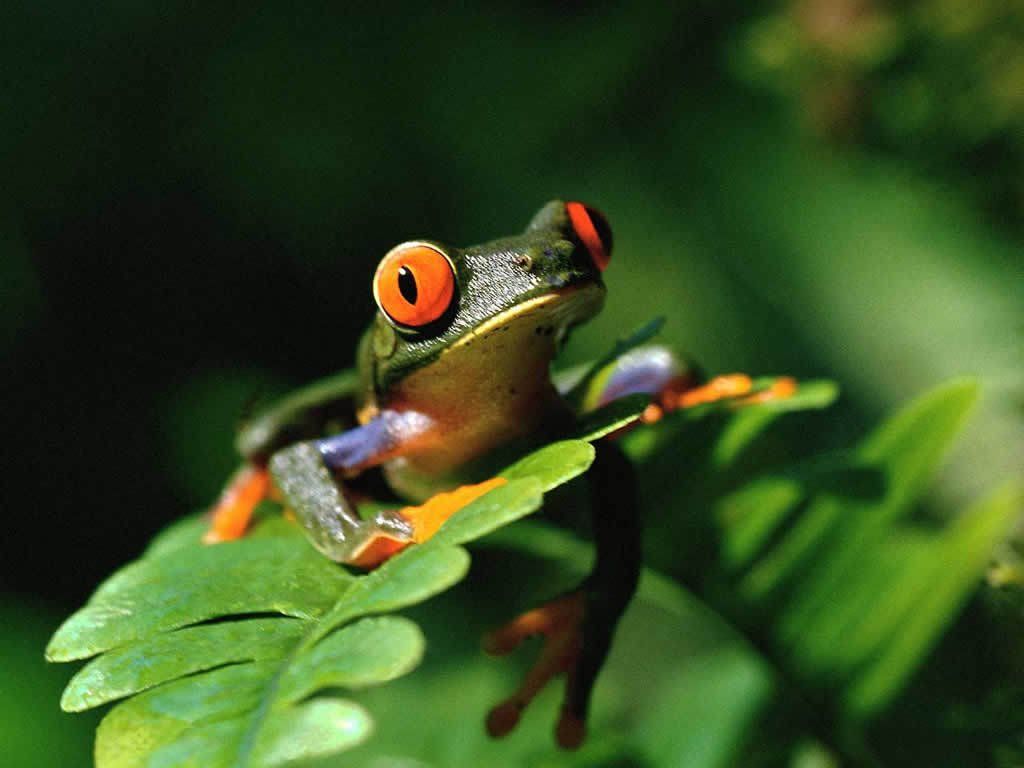

In [110]:
file_name1 = '/tmp/test-1.jpg'
file_name2 = '/tmp/test-2.jpg'
file_name3 = '/tmp/test-3.jpg'
file_name4 = '/tmp/test-4.jpg'
# test image
from IPython.display import Image
Image(file_name1)  

## Inference using our Training Model

Evaluate the image through the network for inteference. The network outputs class probabilities and typically, one selects the class with the maximum probability as the final class output.

**Note:** The output class detected by the network may not be accurate in this example. To limit the time taken and cost of training, we have trained the model only for 5 epochs. If the network is trained for more epochs (say 20), then the output class will be more accurate.

In [115]:
import json
import numpy as np

with open(file_name1, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
    
ic1_classifier.content_type = 'application/x-image'
iceia_classifier.content_type = 'application/x-image'

In [116]:
%%time
result_ic1 = json.loads(ic1_classifier.predict(payload))

CPU times: user 0 ns, sys: 4.14 ms, total: 4.14 ms
Wall time: 32.1 ms


In [117]:
%%time
result_iceia = json.loads(iceia_classifier.predict(payload))

CPU times: user 4.09 ms, sys: 246 µs, total: 4.34 ms
Wall time: 1.3 s


In [118]:
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index1 = np.argmax(result_ic1)
indexeia = np.argmax(result_iceia)

object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']

print("Result: label - " + object_categories[index1] + ", probability - " + str(result_ic1[index1]))
print("Result: label - " + object_categories[indexeia] + ", probability - " + str(result_iceia[indexeia]))

Result: label - frog, probability - 0.6461054682731628
Result: label - frog, probability - 0.9669410586357117
